In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

from utils_week9to11 import LeNet5, train, test

In [3]:
batch_size = 128
epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

## Backdooring under Different Poisoning Ratios
> 区别于上一周的可见后门，不可见后门由于在训练过程中会实时更新后门触发器\
> 我们将不再预处理生成后门数据集，而是在训练过程中实时构建后门样本

- 不可见后门攻击的攻击框架与可见后门基本一致

- 攻击者会干预模型的训练和测试两阶段

- 在训练时投入一定比例的后门样本，在测试时将trigger添加在干净图片上发起攻击

建议使用的API：
- torch.ones_like(input, dtype, device)：生成一个元素值全为1、形如input的多维Tensor
- torch.ones(size, dtype, device)：生成一个元素值全为1的多维Tensor
- torch.norm(input, p)：计算input的L_p范数

In [4]:
# 在干净训练数据集上实时生成后门样本并进行训练，同步更新模型参数和后门trigger
def invisible_trigger_train(model, loader, criterion, optim_model, optim_trigger, trigger, target_label=3):
    model.train()
    train_loss, sample_num = 0., 0

    for inputs, labels in tqdm(loader):
        normal_inputs, normal_labels = inputs.to(device), labels.to(device)

        # TODO：基于正常样本生成后门样本
        backdoor_inputs = normal_inputs + trigger
        # 生成与正常样本标签形状相同但值全部固定为目标标签的张量
        backdoor_labels = torch.full_like(normal_labels, target_label)

        optim_model.zero_grad()
        optim_trigger.zero_grad()

        # TODO：分别计算
        # main_loss->模型在正常样本上的分类loss，
        # backdoor_loss->模型在后门样本上的分类loss，
        # reg_loss->正则化项（trigger的L2范数）
        normal_outputs = model(normal_inputs)
        main_loss = criterion(normal_outputs, normal_labels)

        backdoor_outputs = model(backdoor_inputs)
        backdoor_loss = criterion(backdoor_outputs, backdoor_labels)
        
        reg_loss = torch.norm(trigger, p=2)

        loss = main_loss + 0.5 * backdoor_loss + 0.1 * reg_loss
        loss.backward()
        
        optim_model.step()
        optim_trigger.step()

        sample_num += inputs.shape[0]
        train_loss += loss.item() * inputs.shape[0]
        # break

    train_loss /= sample_num    
    return train_loss

### 数据准备

In [5]:
train_data = torchvision.datasets.MNIST(root='data/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
print('Clean train data is prepared.')

test_data = torchvision.datasets.MNIST(root='data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
print('Clean test data is prepared.')

Clean train data is prepared.
Clean test data is prepared.


### 测试准备

In [6]:
# 在后门测试集上测试攻击成功率ASR
def test_backdoor(model, loader, trigger, device=None, target_label=3):
    device = next(model.parameters()).device if device is None else device
    model.eval()
    total_num = 0.
    correct_num = 0.
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # TODO：基于正常样本生成后门样本
            backdoor_inputs = inputs + trigger
            backdoor_labels = torch.full_like(labels, target_label)
            
            outputs = model(backdoor_inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            total_num += inputs.shape[0]
            correct_num += predicted.eq(backdoor_labels).sum().item()
    acc = correct_num / total_num * 100.
    return acc

### 模型训练及测试

**助教验收**：
- 3种trigger_lr设置下，最佳效果的test_acc > 95.0%、test_asr > 99.0%

In [7]:
# 在不同学习率下优化trigger并植入模型，再测试模型在干净测试集的正常性能
model_lr = 0.01
trained_models = []
invisible_triggers = []

for trigger_lr in [ 0.005, 0.01, 0.05]:
    print('##### Experiment on lr=%.3f #####' % trigger_lr)
    
    model = LeNet5()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # 生成不可见trigger（即全局扰动）
    trigger = torch.rand(28, 28).to(device)
    trigger.requires_grad = True

    # TODO：为模型和trigger分别设置优化器optim_model和optim_trigger
    optim_model = torch.optim.Adam(model.parameters(), lr=model_lr)
    # 较高的 trigger_lr 会加速触发器的优化，但可能破坏隐蔽性；较低的 trigger_lr 则更稳定但收敛慢
    optim_trigger = torch.optim.Adam([trigger], lr=trigger_lr)

    for epoch in range(epochs):
        # 生成后门并植入
        train_loss = invisible_trigger_train(model, train_loader, criterion, optim_model, optim_trigger, trigger)
        # 测试模型正常性能
        test_acc = test(model, test_loader)
        # 测试模型在后门样本上的攻击准确率
        test_asr = test_backdoor(model, test_loader, trigger)
        print('Epoch %d: train_loss %.4f, test_acc %.2f%%, test_asr %.2f%%, ' % (epoch, train_loss, test_acc, test_asr))
    trained_models.append(model)
    invisible_triggers.append((trigger_lr, trigger))

##### Experiment on lr=0.005 #####


100%|██████████| 79/79 [00:00<00:00, 79.14it/s]


Epoch 0: train_loss 0.7894, test_acc 97.76%, test_asr 100.00%, 


100%|██████████| 79/79 [00:01<00:00, 77.69it/s]


Epoch 1: train_loss 0.1155, test_acc 97.82%, test_asr 99.99%, 


100%|██████████| 79/79 [00:01<00:00, 77.21it/s]


Epoch 2: train_loss 0.0934, test_acc 97.78%, test_asr 99.91%, 


100%|██████████| 79/79 [00:00<00:00, 79.98it/s]


Epoch 3: train_loss 0.0884, test_acc 97.67%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 84.56it/s]


Epoch 4: train_loss 0.0907, test_acc 98.34%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch 5: train_loss 0.0775, test_acc 98.32%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 80.58it/s]


Epoch 6: train_loss 0.1189, test_acc 98.02%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 80.49it/s]


Epoch 7: train_loss 0.0757, test_acc 98.04%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 79.05it/s]


Epoch 8: train_loss 0.0765, test_acc 98.05%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 84.49it/s]


Epoch 9: train_loss 0.0731, test_acc 98.12%, test_asr 99.99%, 
##### Experiment on lr=0.010 #####


100%|██████████| 79/79 [00:01<00:00, 76.70it/s]


Epoch 0: train_loss 0.6415, test_acc 97.07%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 83.66it/s]


Epoch 1: train_loss 0.1248, test_acc 97.73%, test_asr 99.46%, 


100%|██████████| 79/79 [00:01<00:00, 78.54it/s]


Epoch 2: train_loss 0.1205, test_acc 97.92%, test_asr 100.00%, 


100%|██████████| 79/79 [00:01<00:00, 78.62it/s]


Epoch 3: train_loss 0.1344, test_acc 97.92%, test_asr 99.98%, 


100%|██████████| 79/79 [00:00<00:00, 82.08it/s]


Epoch 4: train_loss 0.0934, test_acc 98.26%, test_asr 99.59%, 


100%|██████████| 79/79 [00:00<00:00, 80.94it/s]


Epoch 5: train_loss 0.1042, test_acc 97.68%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 81.98it/s]


Epoch 6: train_loss 0.1237, test_acc 97.84%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 81.52it/s]


Epoch 7: train_loss 0.1193, test_acc 98.07%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 81.78it/s]


Epoch 8: train_loss 0.1057, test_acc 97.88%, test_asr 99.99%, 


100%|██████████| 79/79 [00:00<00:00, 81.64it/s]


Epoch 9: train_loss 0.1111, test_acc 98.15%, test_asr 100.00%, 
##### Experiment on lr=0.050 #####


100%|██████████| 79/79 [00:00<00:00, 82.74it/s]


Epoch 0: train_loss 1.3650, test_acc 95.01%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 81.88it/s]


Epoch 1: train_loss 0.2463, test_acc 97.08%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 82.65it/s]


Epoch 2: train_loss 0.2305, test_acc 97.60%, test_asr 99.96%, 


100%|██████████| 79/79 [00:00<00:00, 82.33it/s]


Epoch 3: train_loss 0.4212, test_acc 97.62%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 80.19it/s]


Epoch 4: train_loss 0.1676, test_acc 96.87%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 84.83it/s]


Epoch 5: train_loss 0.2197, test_acc 97.34%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 82.72it/s]


Epoch 6: train_loss 0.3764, test_acc 97.24%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 83.27it/s]


Epoch 7: train_loss 0.2248, test_acc 97.67%, test_asr 100.00%, 


100%|██████████| 79/79 [00:00<00:00, 82.21it/s]


Epoch 8: train_loss 0.2397, test_acc 97.93%, test_asr 99.98%, 


100%|██████████| 79/79 [00:00<00:00, 83.67it/s]

Epoch 9: train_loss 0.2033, test_acc 97.73%, test_asr 100.00%, 


## Demo Backdoor Visualization
- 可视化trigger

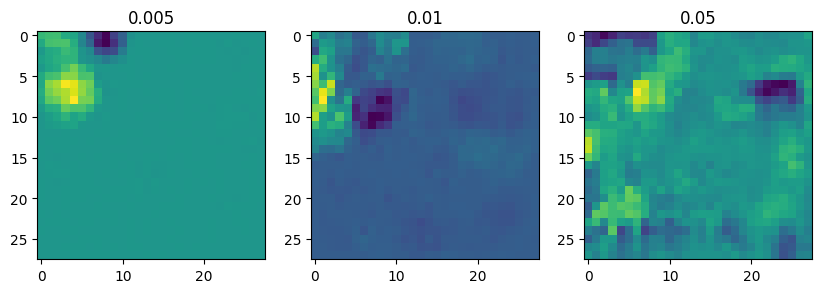

In [8]:
# 如果jupyter内核崩溃加下面两行
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
fig = plt.figure(figsize=(10, 3))
for idx, triggers in enumerate(invisible_triggers):
    ax = fig.add_subplot(1, 3, idx+1)
    
    trigger_lr, trigger = triggers
    ax.set_title(trigger_lr)
    plt.imshow(trigger.cpu().detach().numpy())

- 可视化投毒样本

C:\Users\w2213\AppData\Local\Temp\ipykernel_31136\2046036617.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = test_data[i][0] + trigger.cpu().detach().numpy()


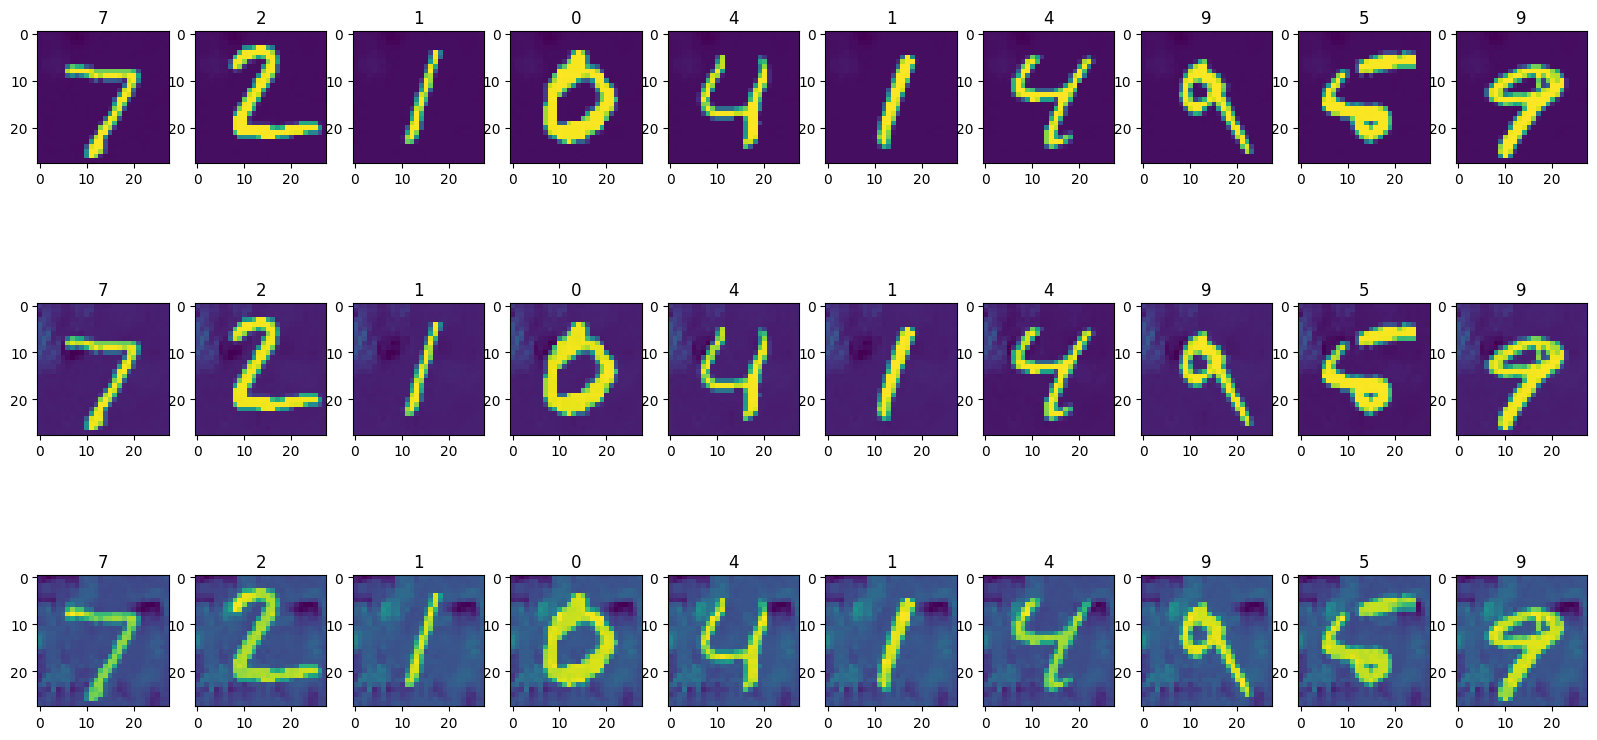

In [9]:
fig = plt.figure(figsize=(20, 10))
for idx, triggers in enumerate(invisible_triggers):
    trigger_lr, trigger = triggers
    for i in range(10):
        ax = fig.add_subplot(3, 10, (idx)*10+i+1)
        x = test_data[i][0] + trigger.cpu().detach().numpy()
        y = test_data[i][1]
        ax.set_title(str(y))
        plt.imshow(x[0])  # 可视化x唯一色彩通道的像素值
    